#Mount Drive, install requirements


In [1]:
from google.colab import drive
import os
import sys
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#%%capture
!pip install pandas==1.3.2
!pip install transformers
# Install Requirements
!pip install -r /content/drive/MyDrive/Github/Content/sources/ChinaFilm/requirements.txt
!apt update
#!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

In [2]:
# PRINT VERSIONS AND ENVIRONMENT
import torch
import pandas as pd

#rint('transformer version {}'.format(transformers.__version__))
print('pytorch version {}'.format(torch.__version__))

# if pandas version < 1.3.2,
# make sured pandas packages were installed and restart runtime.
print('pandas version {}'.format(pd.__version__))

# If GPU is required, make sure it's present
!nvidia-smi

pytorch version 1.10.0+cu111
pandas version 1.3.2
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Import Libraries, set path

In [3]:
# Set path
path_Article = path_wd = '/content/drive/MyDrive/Github/Article'
path_font = path_Article + '/fonts/STHUPO.TTF'
path_img = path_Article + '/img'

path_Content = '/content/drive/MyDrive/Github/Content'
path_ChinaFilm = path_Content + '/tools/sources/ChinaFilm'
path_NRTA = path_Content + '/tools/sources/NRTA'
path_ZGDYPW = path_Content + '/tools/sources/ZGDYPW'

os.chdir(path_wd)

In [4]:
# Import External Libs
import pandas as pd
import numpy as np
import datetime as dt
import re
import random

from IPython.display import display, HTML
import torch
from transformers import AdamW, BartForConditionalGeneration

from selenium import webdriver

import jieba.analyse
tfidf = jieba.analyse.extract_tags
textrank = jieba.analyse.textrank

import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.font_manager as fm

path_fonts = '/content/drive/MyDrive/Github/Article/fonts'
fontprop = fm.FontProperties(fname=path_fonts, size= 15)

font_dirs = [path_fonts, ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)
#font_list = fm.createFontList(font_files)
for font in font_files:
  fm.fontManager.addfont(font)

plt.rcParams['figure.figsize'] = [15, 9]
mp.rcParams['font.family'] = ['Microsoft YaHei']

%matplotlib inline

# Load Libraries Local


#%load_ext autoreload
%reload_ext autoreload
path_Baike = path_Content + '/tools/sources/baike'
os.chdir(path_Baike)
from Baike import Baike
baike = Baike()

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [5]:
# Load Libraries Local
os.chdir(path_Content)

#%load_ext autoreload
%reload_ext autoreload

from tools.sources.ChinaFilm.Record_Registration import Registration
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# Initialize Registration Class
driver = webdriver.Chrome('chromedriver',options=chrome_options)
dy_reg = Registration(driver)

%reload_ext autoreload
os.chdir(path_wd)
from generate import utils

os.chdir(path_ZGDYPW)
from common.utils import DB as db_utils

# import tools for prediction
os.chdir(path_Content)
import predict

/content/drive/MyDrive/Github/Article/generate/utils.py:21: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = fm.createFontList(font_files)
Installing paddle-tiny, please wait a minute......
Paddle enabled successfully......
Paddle enabled successfully......


# Load ZGDYPW and ChinaFilm Records

## Update Record-DON'T USE w/COALB

In [ ]:
# Update ChinaFilm records to reflect latest changes
os.chdir(path_ChinaFilm)

# bypass update in colab, because the connection
# from google to ChinaFilm's server is too slow
#!python update_release.py
#!python update_registration.py

os.chdir(path_ZGDYPW)
!python update_newrelease.py

Traceback (most recent call last):
  File "update_newrelease.py", line 19, in <module>
    how='comprehensive', save=True)
  File "/content/drive/MyDrive/Github/Content/tools/sources/ZGDYPW/zgdypw.py", line 229, in update_contents_of_releases
    fn_contents_of_releases
  File "/content/drive/MyDrive/Github/Content/tools/sources/ZGDYPW/zgdypw.py", line 69, in save_records
    os.rename(path_file, path_file_bk)
FileNotFoundError: [Errno 2] No such file or directory: 'records/contents_of_releases.json' -> 'records/backup/contents_of_releases_20220106_0540.json'


## Import from ZGDYPW and Chinafilm

In [6]:
# Import zgdypow Releases
fp = path_ZGDYPW + '/records/contents_of_releases.json'
df_ZGDYPW_release = pd.read_json(fp)
df_ZGDYPW_release  = df_ZGDYPW_release .sort_values('pubdate', ascending=False)
issue_date = df_ZGDYPW_release['pubdate'].iloc[0]

df_ZGDYPW_release_curr =\
  df_ZGDYPW_release[df_ZGDYPW_release['pubdate'] == issue_date]
df_ZGDYPW_release_curr.loc[:, 'pubdate'] =\
  pd.to_datetime(df_ZGDYPW_release_curr['pubdate'].apply(lambda x: x.rstrip('（重映）')))
df_ZGDYPW_release_curr.loc[:, '上映日期'] =\
  pd.to_datetime(df_ZGDYPW_release_curr['上映日期'].apply(lambda x: x.rstrip('（重映）')))

df_ZGDYPW_release_curr = df_ZGDYPW_release_curr.sort_values('上映日期')

# convert cjk to equivalent unicode characters
os.chdir(path_ZGDYPW)
df_ZGDYPW_release_curr['电影名称'] =\
  df_ZGDYPW_release_curr['电影名称'].apply(db_utils.convert_cjk_characters)

df_ZGDYPW_release_curr['电影名称'] =\
  df_ZGDYPW_release_curr['电影名称'].apply(lambda x: x.strip())

print(issue_date)
print(df_ZGDYPW_release_curr.shape)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


2022-01-04
(10, 9)


In [7]:
# Import ChinaFilm Reg
df_ChinaFilm_reg = pd.read_json(
    path_ChinaFilm + '/records/contents_of_registrations.json', orient='record')
#df_ChinaFilm_reg['匹配片名'] = df_ChinaFilm_reg['片名']

# Import ChinaFilm Releases
df_ChinaFilm_release = pd.read_json(
    path_ChinaFilm + '/records/contents_of_releases.json')

## Merge ChinaFilm release to ZGDYPW release

In [8]:
# Match df_ZGDYPW_release_currelease_curr to df_cf_releases
df_ZGDYPW_release_curr['片名_CFrelease'] = df_ZGDYPW_release_curr['电影名称']
df_matched_rel = df_ChinaFilm_release[
  df_ChinaFilm_release['片名'].isin(df_ZGDYPW_release_curr['电影名称'])]
df_matched_rel['电影名称'] = df_matched_rel['片名'].copy()
idx_no_match = df_ZGDYPW_release_curr.loc[
  ~df_ZGDYPW_release_curr['电影名称'].isin(df_matched_rel['片名'])].index
df_ZGDYPW_release_curr.loc[df_ZGDYPW_release_curr.index.isin(idx_no_match), '片名_CFrelease'] = None
#df_ZGDYPW_release_curr.loc[df_ZGDYPW_release_curr['匹配片名'].isna(), :]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [9]:
df_ZGDYPW_release_curr.columns

Index(['电影名称', 'pubtitle', 'pubdate', 'publink', '上映日期', '导演', '国别/地区',
       'img_remote', '主演', '片名_CFrelease'],
      dtype='object')

In [10]:
cols = ['电影名称', '上映日期', '导演', '主演', '国别/地区', '片名_CFrelease']

num_ZGDYPW_not_in_ChinaFilm_release = df_ZGDYPW_release_curr.loc[
  (df_ZGDYPW_release_curr['片名_CFrelease'].isna()) & 
  (df_ZGDYPW_release_curr['国别/地区'] == '中国'), cols].shape[0]

df_ZGDYPW_release_curr.loc[
  (df_ZGDYPW_release_curr['片名_CFrelease'].isna()) & 
  (df_ZGDYPW_release_curr['国别/地区'] == '中国'), cols]

,电影名称,上映日期,导演,主演,国别/地区,片名_CFrelease
258,带你去见我妈,2022-01-07,蓝鸿春,郑润奇、钟少贤、卢珊,中国,None
268,纹身,2022-01-14,陆⼀铜,赵⽂卓、徐冬冬,中国,None
264,向着明亮那方,2022-01-15,兰茜雅,李念泽、赵易、俞昆,中国,None
265,“炼”爱,2022-03-18,董雪莹,赵⽂卓、徐冬冬,中国,None


In [11]:
df_ZGDYPW_release_curr.loc[
  (df_ZGDYPW_release_curr['片名_CFrelease'].isna()) & 
  (df_ZGDYPW_release_curr['国别/地区'] == '中国'), '电影名称'].to_numpy()

array(['带你去见我妈', '纹身', '向着明亮那方', '“炼”爱'], dtype=object)

In [12]:
# RUN ONLY ONCE
found_cfReleases = [None]*num_ZGDYPW_not_in_ChinaFilm_release 
df_ZGDYPW_release_curr.loc[
  (df_ZGDYPW_release_curr['片名_CFrelease'].isna()) & 
  (df_ZGDYPW_release_curr['国别/地区'] == '中国'), '片名_CFrelease'] = found_cfReleases

df_matched_rel = df_ChinaFilm_release[
  df_ChinaFilm_release['片名'].isin(df_ZGDYPW_release_curr['片名_CFrelease'])]
df_matched_rel.rename(columns={'片名':'片名_CFrelease'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
df_ChinaFilm_release.columns

Index(['序号', '电影类别', '编码', '公映证号', '片名', '第一出品单位', '公示批次链接', '公示名称', '公示日期'], dtype='object')

In [14]:
# Merge
df_ZGDYPW_release_curr =\
  df_ZGDYPW_release_curr.merge(df_matched_rel, on='片名_CFrelease', how='left')
df_ZGDYPW_release_curr = df_ZGDYPW_release_curr.rename(columns={'电影类别':'类别'})

In [15]:
df_ZGDYPW_release_curr.columns

Index(['电影名称', 'pubtitle', 'pubdate', 'publink', '上映日期', '导演', '国别/地区',
       'img_remote', '主演', '片名_CFrelease', '序号', '类别', '编码', '公映证号', '第一出品单位',
       '公示批次链接', '公示名称', '公示日期'],
      dtype='object')

## Search ChinaFilm release [Optional]

In [29]:
# Search Release Records
df_ChinaFilm_release[df_ChinaFilm_release['片名'].str.contains('炼')]

,序号,电影类别,编码,公映证号,片名,第一出品单位,公示批次链接,公示名称,公示日期


## Merge ChinaFilm Reg to ZGDYPW release

In [16]:
# Match df_ZGDYPW_release_curr to df_reg
cols = ['电影名称', 'pubtitle', 'pubdate', '上映日期', '导演', '主演', '第一出品单位', '类别']
df_ZGDYPW_release_curr['片名_CFreg'] = df_ZGDYPW_release_curr['电影名称']
df_matched = \
  df_ChinaFilm_reg[df_ChinaFilm_reg['片名'].isin(df_ZGDYPW_release_curr['片名_CFreg'].to_numpy())]
idx_no_match = df_ZGDYPW_release_curr.loc[~df_ZGDYPW_release_curr['片名_CFreg'].isin(
    df_matched['片名'].to_numpy())].index
df_ZGDYPW_release_curr.loc[df_ZGDYPW_release_curr.index.isin(idx_no_match), '片名_CFreg'] = None
df_ZGDYPW_release_curr.loc[(df_ZGDYPW_release_curr['片名_CFreg'].isna()) & 
    (df_ZGDYPW_release_curr['国别/地区'] == '中国'), cols]

,电影名称,pubtitle,pubdate,上映日期,导演,主演,第一出品单位,类别


In [17]:
df_ZGDYPW_release_curr.loc[(df_ZGDYPW_release_curr['片名_CFreg'].isna()) & 
    (df_ZGDYPW_release_curr['国别/地区'] == '中国'), '电影名称'].to_numpy()

array([], dtype=object)

In [ ]:
# assign manually found titles to df_curr_releases
found_reg = ['一年之痒', '新花木兰']
df_ZGDYPW_release_curr.loc[(df_ZGDYPW_release_curr['片名_CFreg'].isna()) & 
    (df_ZGDYPW_release_curr['国别/地区'] == '中国'), '片名_CFreg'] = found_reg

In [44]:
df_ChinaFilm_reg.columns

Index(['电影类别', '备案立项号', '片名', '备案单位', '编剧', '备案结果', '备案地', '梗概', '公示日期',
       '公示批次名称', '备案详细页链接', '公示批次链接'],
      dtype='object')

In [18]:
# Merge
cols = ['电影名称', 'pubtitle', 'pubdate', '上映日期', '导演', '主演', '第一出品单位', '电影类别']
df_ChinaFilm_reg['片名_CFreg'] = df_ChinaFilm_reg['片名']
df_matched = df_ChinaFilm_reg.loc[
  df_ChinaFilm_reg['片名_CFreg'].isin(df_ZGDYPW_release_curr['片名_CFreg']),:]                    
df_matched.rename(columns={'公示日期':'备案公示日期'}, inplace=True)
df_curr = df_ZGDYPW_release_curr.merge(df_matched, on='片名_CFreg', how='left')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [19]:
# Calculate time elapsed since release permit
df_curr ['备案公示日期'] = df_curr ['备案公示日期'].apply(
    lambda x: pd.to_datetime(x, infer_datetime_format=True))
df_curr ['备案至今'] = df_curr ['pubdate'] - df_curr['备案公示日期']

In [20]:
df_curr.columns

Index(['电影名称', 'pubtitle', 'pubdate', 'publink', '上映日期', '导演', '国别/地区',
       'img_remote', '主演', '片名_CFrelease', '序号', '类别', '编码', '公映证号', '第一出品单位',
       '公示批次链接_x', '公示名称', '公示日期', '片名_CFreg', '电影类别', '备案立项号', '片名', '备案单位',
       '编剧', '备案结果', '备案地', '梗概', '备案公示日期', '公示批次名称', '备案详细页链接', '公示批次链接_y',
       '备案至今'],
      dtype='object')

## Search ChinaFilm reg, Baidu [Optional]

In [ ]:
i = 3 ### enter idx of record

In [ ]:
# Search by company name in ChinaFilm Reg
cols = ['片名', '备案立项号', '备案单位', '编剧', '梗概', '公示日期']
if not pd.isna(df_ZGDYPW_release_curr.loc[i, '第一出品单位']):
  df_ChinaFilm_reg.loc[
    df_ChinaFilm_reg['备案单位'].fillna('').str.contains(
        df_ZGDYPW_release_curr.loc[i, '第一出品单位']), cols]

In [ ]:
# Search by Title in Baidu Baike
baike.search_for_content(df_ZGDYPW_release_curr.loc[i, '电影名称'])

In [ ]:
# Search by kw in synopsis in ChinaFilm Reg
cols = ['片名', '备案立项号', '备案单位', '编剧', '梗概', '公示日期']
df_ChinaFilm_reg.loc[df_ChinaFilm_reg['梗概'].fillna('').str.contains('酒店经理'), cols]

In [ ]:
# Search by partial company name in ChinaFilm Reg
df_ChinaFilm_reg.loc[df_ChinaFilm_reg['备案单位'].fillna('').str.contains(
   '光线'), cols]

In [ ]:
# Search by custom name in ChinaFilm Reg
df_ChinaFilm_reg.loc[df_ChinaFilm_reg['片名'].fillna('').str.contains(
    '一年之痒'), cols]#.loc[4268,'梗概']

In [ ]:
# Search by writer in ChinaFilm Reg
df_ChinaFilm_reg.loc[df_ChinaFilm_reg['编剧'].fillna('').str.contains(
    '唐晓白'), cols]

In [ ]:
# Search by kw in synopsis in ChinaFilm Reg
df_ChinaFilm_reg.loc[df_ChinaFilm_reg['梗概'].fillna('').str.contains(
  '焚'), cols]

In [ ]:
# Search by partial company name in ChinaFilm Reg
df_ChinaFilm_reg.loc[df_reg['备案单位'].fillna('').str.contains(
   '天马'), cols]

In [ ]:
# Search by custom name in ChinaFilm Reg
df_ChinaFilm_reg.loc[df_ChinaFilm_reg['片名'].fillna('').str.contains(
    '爱你'), cols]

In [ ]:
# Search by writer in ChinaFilm Reg
df_ChinaFilm_reg.loc[df_ChinaFilm_reg['编剧'].fillna('').str.contains(
    '唐晓白'), cols]

## Search for foreign film synopsis [Optional]

In [ ]:
cols = ['电影名称', '备案立项号', '备案单位', '编剧', '梗概', '公示日期']
df_curr[cols]

In [ ]:
baike.search_for_content('反恐特战队：清盘行动')

In [ ]:
df.loc[df['电影名称'] == '反恐特战队：清盘行动', '梗概'] = '拉维尔将军联合伊戈少校设立一个特别行动组，目标是铲除北高加索地区的头号恐怖分子巴萨耶夫的故事。'

#Run Models for prediction

## Predict and extract features

In [21]:
os.chdir(path_Content) # change to the Content directory

# predict alternative title
df_curr['预测片名'] = predict.predict_title(df_curr['梗概'].tolist())

# predict genre
df_curr['类型'] = predict.predict_genre(df_curr['梗概'].tolist())

# predict time period
df_curr['年代'] = predict.predict_time(df_curr['梗概'].tolist())

# extract keywords, topK=10
df_curr['kw'] = df_curr['梗概'].apply(predict.extract_keywords, topK=10).copy()

# identify main characters
df_curr['主要角色'] = df_curr['梗概'].apply(predict.identify_characters).copy()

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:349: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/561 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/390M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/566 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/390M [00:00<?, ?B/s]

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.112 seconds.
Prefix dict has been built successfully.


## Interactively adjust features

### adjust genre

In [22]:
# adjust genre
df_curr['类型_ext'] = df_curr['类型'].copy()

In [23]:
i = 0
batch = 10
df_curr['类型_ext'][i:i+batch].to_numpy()

array(['农村', '都市', '传记', '青少', '都市', '传奇', '都市', '都市', '其它', '都市'],
      dtype=object)

In [ ]:
#i+= batch
print('{} - {}'.format(i, i+batch))
#df_curr['类型_ext'][i:i+batch].to_numpy() # copy out put to next cell to modify genre

In [24]:
df_curr['类型_ext'].iloc[i:i+batch] = \
['农村', '职业', '传记', '青少', '爱情', '传奇', '传奇', '爱情', '其它', '爱情']

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [25]:
# run cell, click make  interactive tables at the lower left to edit
df_curr[['电影名称', '类型', '类型_ext', '梗概', '备案立项号']]

,电影名称,类型,类型_ext,梗概,备案立项号
0,五埠岭过大年,农村,农村,一个拥有六百年历史的山村，人们以山为伴，垒石而居，保留着中国农耕文化的传统基因。当年节如期而...,影纪备字[2019]第054号
1,独家头条,都市,职业,通过展现一档电视娱乐新闻栏目里一群年轻媒体人追查一个娱乐热点新闻的全过程，反映娱乐行业众生相...,影剧备字[2019]第5553号
2,张之洞,传记,传记,晚清重臣张之洞一生致力于教育改革，实业救国。奈何时局动荡，清政府腐朽透顶，张之洞虽穷尽一生之...,影剧备字[2018]第4764号
3,我的体育老师,青少,青少,南武中学新来的体育老师刘昊辰面对班主任等老师们的霸课和家长的抗议并不服输，通过斗争终于帮助高...,影剧备字[2019]第1807号
4,带你去见我妈,都市,爱情,一个潮汕男人带一个离过婚的外地女孩回家见父母准备结婚的故事！一段纯粹的爱情面临家庭的考验，引...,影剧备字[2020]第1001号
5,纹身,传奇,传奇,阿昌遭阴谋陷害，成了敌人和自己人共同要杀的对象。 他带着女儿逃到自己最相信的朋友罗洪甫家，但...,影剧备字[2017]第3639号
6,纹身,都市,传奇,三十年代一个小镇的纹身师阿昌独自和女儿生活，阿昌认为女儿是妻子和外人生的，对她很冷漠。阿昌莫...,影剧备字[2012]第251号
7,爱情的代驾,都市,爱情,一部讲述事业爱情双失意的男青年钟成奎为实现人生反转，为神秘富二代当职业替身，结果遭遇多重意外...,影剧备字〔2021〕第1482号
8,向着明亮那方,其它,其它,《向着明亮那方》由几个独立故事组合而成，这些故事取材于中福会等出版社推出的国产优秀原创绘本。...,影动备字〔2021〕第007号
9,世界唯一一个你,都市,爱情,实习医生陈筱澜与音乐系学生穆阳一见倾心，成为一对甜蜜恋人。然而好景不长，陈筱澜突患癌症。不忍...,影剧备字[2019]第6172号


## identify multireg records

In [26]:
df_curr['multireg'] = 0
df_curr.loc[5, 'multireg'] = 1
df_curr.loc[6, 'multireg'] = 2

## download, process posters

In [27]:
# Download picture
import urllib.request
from IPython.display import Image as Img
import PIL

for img in df_curr['img_remote'].to_numpy():
  fp_local = path_ZGDYPW + '/img/' + img.split('/')[-1]
  urllib.request.urlretrieve(img, fp_local)
  image = PIL.Image.open(fp_local)
  image_cropped = image.crop((2,2, image.size[0]-2, image.size[1]-2))
  image_sharpened = image_cropped.filter(PIL.ImageFilter.SHARPEN)
  display(image_sharpened)
  image_sharpened.save(fp_local)

Output hidden; open in https://colab.research.google.com to view.

## Save Records Curr Issue

In [28]:
# Save records for current release issue
df_curr.to_pickle(path_wd + '/records/df_releases_zgdypw_{}.pkl'.format(issue_date))

In [ ]:
#df_curr = pd.read_pickle(path_wd + '/records/df_releases_zgdypw_{}.pkl'.format(issue_date))

# View Table


In [30]:
"""
# 出品单位变更
tmp = df[['备案单位','第一出品单位']].fillna('').apply(
    lambda x: re.search(x['第一出品单位'], x['备案单位']), axis=1).to_frame()
idx_co_change = tmp[tmp[0].isna()].index
df['公司变更'] = 0
df.loc[idx_co_change, '公司变更'] = 1

# 出品单位变更
df_view.loc[df_view['公司变更'] == 0, '备案单位'] = ''
df_view.rename(columns={'备案单位':'原备案单位'}, inplace=True)
df_view.drop('公司变更', axis=1, inplace=True)
""" 
# 改名
df_view = df_curr.copy()
df_view.loc[df_view['电影名称'] == df_view['片名_CFrelease'], '片名_CFrelease'] = ''
df_view.rename(columns={'片名_CFrelease':'备案名'}, inplace=True)


# 备案修改
df_view.loc[df_view['备案结果'].fillna('').str.contains('修改'),'备案结果'] = '是'
df_view.loc[df_view['备案结果'].fillna('').str.contains('同意'),'备案结果'] = ''
df_view.rename(columns={'备案结果':'是否修改'}, inplace=True)

# 备案至今
df_view['备案至今'] = round((df_view['备案至今'].dt.days + 60) / 365, 1)
#df_view.sort_values(by='备案至今', ascending=False, inplace=True)
#df_view['备案至今'] = df_view['备案至今'].apply(lambda x: '> ' + str(x) + ' 年')

# 公映许可至今

# 上映日期(月)
df_view['公示日期'] = pd.to_datetime(df_view['公示日期'])
df_view['距离公映许可'] = (12*(df_view['上映日期'].dt.year-df_view['公示日期'].dt.year) 
  + (df_view['上映日期'].dt.month - df_view['公示日期'].dt.month))

In [31]:
# soft df_view by years since registration in descending order
df_view = df_view.sort_values('备案至今', ascending=False)

# [7] Generate Article

##[T1] Title

In [52]:
# Title
T1 = '~{}新片上映预告~'.format(issue_date)
T1

'~2022-01-04新片上映预告~'

##[P1] Overview

In [ ]:
df_view[df_view['国别/地区'] == '中国'].drop_duplicates(['电影名称'], keep='first')

In [60]:
df_genre_sorted = df_curr.drop_duplicates(['电影名称'], keep='first').\
    groupby('类型_ext')['电影名称'].count().rename(
    '数量').reset_index().sort_values('数量', ascending=False)
df_genre_sorted['数量'] = df_genre_sorted['数量'].astype('int')

P1 = ''
P1 +='{}年{}月{}日，'.format(issue_date.split('-')[0], 
                            issue_date.split('-')[1],
                            issue_date.split('-')[2])
P1 += '又一批电影排期上映，'
P1 += '从获取公映许可到排期上映平均{}个月，'.\
  format(round(df_view.drop_duplicates(['电影名称'], keep='first')\
               ['距离公映许可'].fillna(0).mean(),1))
P1 += '从备案到上映平均{}年。'.format(round(\
  df_view.drop_duplicates(['电影名称'], keep='first')['备案至今'].mean(),1))

P1 += '其中，国产片有{}部，进口片有{}部'.format(
    df_view[df_view['国别/地区'] == '中国'].drop_duplicates(
        ['电影名称'], keep='first').shape[0],
    df_view[df_view['国别/地区'] != '中国'].drop_duplicates(
        ['电影名称'], keep='first').shape[0])

n_domestic = df_view.drop_duplicates(['电影名称'], keep='first')['备案立项号'].\
    dropna().str.contains('影剧备字').shape[0]
n_domestic_story = df_view.drop_duplicates(['电影名称'], keep='first')['备案立项号'].\
    dropna().str.contains('影剧备字').sum()
if n_domestic - n_domestic_story > 0:
  P1 += '，故事片有{}部'.format(n_domestic_story)
  n_domestic_documentary = \
    df_view.drop_duplicates(['电影名称'], keep='first')['备案立项号'].dropna().\
      str.contains('影纪备字').sum()
  if n_domestic_documentary > 0:
    P1 += '，纪录片有{}部'.format(n_domestic_documentary)

P1 += '。'

P1 += '国产片中，改过名字的有{}部，'.format(
    df_view.loc[df_view['备案名'] != '',:].shape[0])
P1 += '换过第一出品单位的有{}部，'.format(
    df_view.loc[df_view['备案单位'] != '',:].shape[0])
P1 += '修改后才通过备案的有{}部，'.format(
    df_view.loc[df_view['是否修改'] == '是',:].shape[0])
if df_curr.shape[0] - df_view.shape[0] > 0:
  P1 += '神秘到无迹可寻的有{}部，'.format(df_curr.shape[0] - df_view.shape[0])
P1 += '题材排名前五的分别是{}'.format('、'.join(df_genre_sorted['类型_ext'][:4]))
P1 += '和{}。'.format(df_genre_sorted['类型_ext'][4:5].iloc[0])

#P1 += '瓜熟蒂落实属不易。'

print(P1) 

2022年01月04日，又一批电影排期上映，从获取公映许可到排期上映平均5.9个月，从备案到上映平均2.9年。其中，国产片有10部，进口片有0部，故事片有7部，纪录片有2部。国产片中，改过名字的有5部，换过第一出品单位的有11部，修改后才通过备案的有2部，题材排名前五的分别是爱情、传奇、传记、其它和农村。


## [P1A] genre overview

In [57]:
# sanity check
print(df_curr['电影类别'].to_numpy())
print(df_ChinaFilm_reg['电影类别'].unique())

['纪录片' '故事片' '故事片' '故事片' '故事片' '故事片' '故事片' '故事片' '动画片' '故事片' '纪录片']
['故事影片' '动画影片' '纪录影片' '科教影片' '特种影片' '合拍影片' '故事片' '纪录片' '科教片' '动画片'
 '重大历史题材片' '特种片' '合拍片' '协拍片' None]


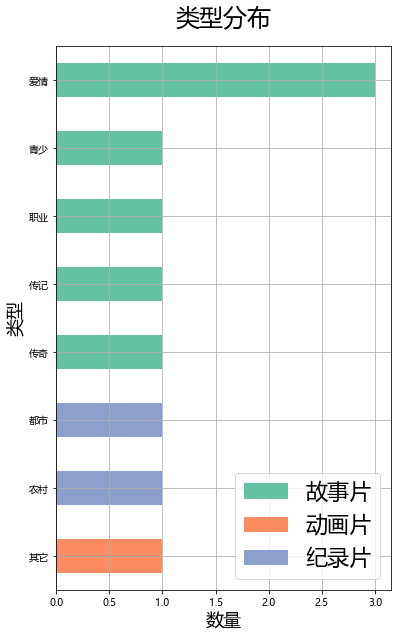

In [59]:
fp_plot_genre, df_by_genre = utils.plot_genre(
    df_curr.drop_duplicates(['电影名称'], keep='last'), 
    'ALL_{}'.format(issue_date), 
    stacked=True, 
    return_df=True)

## [P1B] Time Period

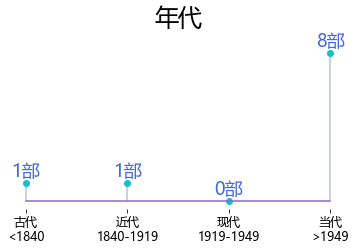

In [62]:
fp_plot_time, df_by_time = utils.plot_time(
    df_curr.drop_duplicates(['电影名称'], keep='first'), 
    issue_date, return_df=True)

##[P2] Oldest project

In [78]:
P2 = ''
P2 += '怀胎最久的影片是《{}》，'.format(df_view.iloc[0]['电影名称'])
P2 += '从备案到排期公映超过{}年'.format(df_view.iloc[0]['备案至今'])
if df_view['距离公映许可'].fillna(0)[0] == 0:
         '，已获取公映许可证，但尚未公示（通常一个月一次）。'
else:
  P2 += '，从获取公映许可到排期上映超过{}个月'.format(
      round(df_view['距离公映许可'].fillna(0)[0], 0))
  
if df_view[df_view['电影名称'] == df_view.iloc[0]['电影名称']].shape[0] > 1:
  P2 += '，历经了{}次备案'.format(
      df_view[df_view['电影名称'] == df_view.iloc[0]['电影名称']].shape[0])
  ls_co = df_view[df_view['电影名称'] == df_view.iloc[0]['电影名称']]\
    ['备案单位'].to_list()
  if len(set(ls_co)) > 1:
    P2 += '，备案单位从{}变更为{}'.format(ls_co[::-1][0], '、'.join(ls_co[::-1][1:]))
if df_view.iloc[0]['片名_CFreg'] != df_view.iloc[0]['电影名称']:
  P2 += '名字从《{}》进化成了《{}》'.format(
      df_view.iloc[0]['片名_CFreg'], df_view.iloc[0]['电影名称'])

record_longest = df_view[df_view['电影名称'] == df_view.iloc[0]['电影名称']]
if (not pd.isna(record_longest['第一出品单位']).iloc[0]) and \
    (record_longest['备案单位'].iloc[0] != record_longest['第一出品单位'].iloc[0]):
  P2 += '，第一出品方历经了{}'.format('、'.join(record_longest['原备案单位']))
  P2 += '最终由{}接手。'.format(df_view.iloc[0]['第一出品单位'])
P2 += '。'

print(P2)

怀胎最久的影片是《纹身》，从备案到排期公映超过10.0年，从获取公映许可到排期上映超过12.0个月，历经了2次备案，备案单位从中影上元（北京）国际影视投资有限公司、上海世与影视文化传播投资有限公司、丽江古纳本影视文化发展有限公司变更为北京凯视芳华文化传播有限公司。


## [P3] projects > 3-year-old

In [79]:
ls_name_3plus_year = df_view.drop_duplicates(['电影名称'], keep='first').\
  loc[df_view['备案至今']>3, '电影名称'].tolist()[1:]
ls_name_3plus_year = ['《'+ name + '》' for name in ls_name_3plus_year]
P3 = ""
P3 += '坚守了3年以上的影片还有{}。'.format('、'.join(ls_name_3plus_year))

print(P3)

坚守了3年以上的影片还有《张之洞》。


## [P4] public company affiliation

In [ ]:
cols = ['电影名称', '类型', '类型_ext', '梗概', '备案立项号', '第一出品单位', '备案单位']
df_view[cols]

In [80]:
df_view['第一出品单位'].unique()

array([nan, '北京太阳花开影视文化有限公司', '广东群星影业传媒集团有限公司', '山东螭龙影视文化传媒有限公司',
       '广东多多影视传媒有限公司', '重庆山那边影视文化有限公司', '宁夏群英影业有限公司'], dtype=object)

In [82]:
# 本批次中与上市影视公司关联的项目有
info_public_film_co = pd.read_csv(path_wd +'/reference/info_public_film_co.csv', 
                                  index_col=0, encoding='utf-8-sig')
ls = info_public_film_co['公司简称'].apply(eval).sum()
pat_public = '|'.join(ls)
pat_public += '|阿里|腾讯|爱奇艺|英皇|寰亚|银都|美亚|大盛|儒意|灿星|横店|博纳|麦颂'
df_focus = df_view.loc[
    df_view['第一出品单位'].fillna('').str.contains(pat_public, regex=True)]

df_focus2 = df_view.loc[
    df_view['备案单位'].fillna('').str.contains(pat_public, regex=True)]

df_focus = pd.concat([df_focus, df_focus2], axis=0)
df_focus

,电影名称,pubtitle,pubdate,publink,上映日期,导演,国别/地区,img_remote,主演,备案名,序号,类别,编码,公映证号,第一出品单位,公示批次链接_x,公示名称,公示日期,片名_CFreg,电影类别,备案立项号,片名,备案单位,编剧,是否修改,备案地,梗概,备案公示日期,公示批次名称,备案详细页链接,公示批次链接_y,备案至今,预测片名,类型,年代,kw,主要角色,类型_ext,multireg,距离公映许可


In [ ]:
idx_to_keep = []
df_focus_narrowed = df_focus[df_focus.index.isin(idx_to_keep)]

In [ ]:
df_focus_narrowed

In [83]:
P4 = ''
P4 += '国产片中，ContentAI分析识别出{}部上市影视公司关联项目'.format(df_focus.shape[0])
if df_focus.shape[0] > 0:
  P4 += '，占比{}%。'.format(round( (df_focus.shape[0]/(df_view.shape[0]-1)*100), 2 ) )
  P4 += '结合题材与出品方实力，ContenAI聚焦关注《{}》'.format(
      '》、《'.join(df_focus_narrowed['电影名称']))
  P4 += '，类型包括了{}'.format(
      '、'.join(df_focus_narrowed.修正类型.unique()))
#P4 += '，两部进口片质量都很不错，具有较大的竞争力'
P4 += '。'

print(P4)

国产片中，ContentAI分析识别出0部上市影视公司关联项目。


##[P5] preview with wordcloud 

In [84]:
P5 = ''
P5 = '\n看图识新片。'

print(P5)


看图识新片。


In [85]:
from IPython.display import Image as Img
import PIL

path_posters = '/content/drive/MyDrive/Github/Article/img/posters'
path_icon = '/content/drive/MyDrive/Github/Article/img/genre_icon'

#df_label2img.to_json(path_records + '/df_label2img.json')
df_label2img = pd.read_json(path_wd + '/records/df_label2image.json')

In [86]:
df_curr['类型_ext'].unique()

array(['农村', '职业', '传记', '青少', '爱情', '传奇', '其它', '都市'], dtype=object)

In [ ]:
df_label2img.to_numpy()

In [88]:
df_view['src_img'] = None
df_view['tgt_img'] = None

In [89]:
genre_count = df_view.groupby('类型_ext')['电影名称'].count(
    ).rename('类型数量').reset_index()
df_view = df_view.merge(genre_count, on='类型_ext', how='left')
df_view = df_view.sort_values(['类型数量','上映日期'], ascending=[False, True])

In [90]:
### to be moved to tools in Content Repo

def get_writer_other_works(writer, curr_work, df_ChinaFilm_reg):
  """
  return:
    List[str]
  """
  writer_works = []
  if df_ChinaFilm_reg[
    df_ChinaFilm_reg['编剧'].fillna('').str.contains(writer)].shape[0]>1:
      writer_works =\
        df_ChinaFilm_reg.loc[
          df_ChinaFilm_reg['编剧'].fillna('').str.contains(writer), '片名']
      writer_works = writer_works.to_list()
      # exlude current work
      writer_works = [work for work in writer_works if work !=curr_work]
  return writer_works

In [91]:
### to be moved to tools in Content Repo
def get_company_other_releases(company:str, 
                               curr_work:str, 
                               df_ChinaFilm_release: pd.DataFrame, 
                               days:int=180):
  """
  return:
    List[str]
  """
  df_co_other_releases =[]
  df_co_other_releases = df_ChinaFilm_release[
    df_ChinaFilm_release['第一出品单位'].isin(company.split('、'))]
  
  cut_off_date =\
    df_co_other_releases['公示日期'].astype('datetime64[ns]')-pd.Timedelta(days)
  df_co_other_releases =\
    df_co_other_releases[
      df_co_other_releases['公示日期'].astype('datetime64[ns]') > cut_off_date]
  
  ls_co_other_releases = df_co_other_releases['片名'].to_list()
  ls_co_other_releases =\
    [release for release in ls_co_other_releases if release != curr_work]
  
  return ls_co_other_releases

In [92]:
df_view.columns

Index(['电影名称', 'pubtitle', 'pubdate', 'publink', '上映日期', '导演', '国别/地区',
       'img_remote', '主演', '备案名', '序号', '类别', '编码', '公映证号', '第一出品单位',
       '公示批次链接_x', '公示名称', '公示日期', '片名_CFreg', '电影类别', '备案立项号', '片名', '备案单位',
       '编剧', '是否修改', '备案地', '梗概', '备案公示日期', '公示批次名称', '备案详细页链接', '公示批次链接_y',
       '备案至今', '预测片名', '类型', '年代', 'kw', '主要角色', '类型_ext', 'multireg',
       '距离公映许可', 'src_img', 'tgt_img', '类型数量'],
      dtype='object')

In [93]:
idx_actor = df_view['主演'].dropna().index

for i, row in df_view.drop_duplicates('电影名称').iterrows():
  ls = [row['电影名称']] * 20
  ls += [row['预测片名']] *6
  ls += row['主要角色']*3
  if i in idx_actor:
    ls += row['主演']*3
  ls += [row['类型_ext']] *3
  ls += [row['年代']]*2
  ls += row['kw']

  img_fn = df_view.loc[i, 'src_img']
  img_fn = df_label2img.loc[
    df_label2img['label'] == row['类型_ext'], 'fn'].iloc[0]

  # Title
  txt = '\n《{}》'.format(row['电影名称'])
  if row['电影名称'] != row['片名_CFreg']:
    txt += '\n原备案片名：《{}》'.format(row['片名_CFreg'])

  # Genre
  if not pd.isna(row['电影类别']):
    txt += '\n类别：{}'.format(row['电影类别'])
    
  # Release Date
  txt += "\n上映日期：{}".format(str(row['上映日期']).split(' ')[0])
  if row['国别/地区'] == '中国':
    if pd.isna(row['距离公映许可']):
      txt += '\n已获得公映许可，尚未公示'
    else:
      txt += '\n获得公映许可至今{}个月'.format(row['距离公映许可'])
    txt += '，备案至今超过{}年'.format(row['备案至今'])
  
  # Key Creative
  txt += '\n主演：{}'.format(row['主演']) 
  txt += '\n导演：{}'.format(row['导演'])
  
  if not pd.isna(row['编剧']):
    txt += '\n编剧：{}'.format(row['编剧'])
    writer_other_works =\
     get_writer_other_works(row['编剧'], row['片名_CFreg'], df_ChinaFilm_reg)
    if len(writer_other_works):
      txt += '\n编剧的其它作品：《{}》'.format('》、《'.join(writer_other_works))

  # Main Characters
  if len(row['主要角色']) > 0:
    txt += '\n主要角色：{}'.format('、'.join(row['主要角色']))
  txt += '\n类型：{}'.format(row['类型_ext'])
  txt += '\n国别/地区：{}'.format(df_view.loc[i, '国别/地区'])

  # Company
  if not pd.isna(row['第一出品单位']):
    txt += '\n第一出品单位：{}'.format(row['第一出品单位'])
    ls_co_other_releases =  get_company_other_releases(row['第一出品单位'],
                                                       row['电影名称'],
                                                       df_ChinaFilm_release)
    if len(ls_co_other_releases) > 0:
      txt += '\n出品单位近期推出的其它影片：《{}》'.format(
          '》、《'.join(ls_co_other_releases))
      
    # if there is a primary company change
    if row['备案单位'] != row['第一出品单位']:
      txt +=  '\n原备案单位：{}'.format(row['备案单位'])
      ls_co_other_releases =  get_company_other_releases(
        row['备案单位'], row['电影名称'],df_ChinaFilm_release)
      if len(ls_co_other_releases) > 0:
        txt += '\n备案单位近期推出的其它影片：《{}》'.format(
            '》、《'.join(ls_co_other_releases))
  else:
    txt +=  '\n备案单位：{}'.format(row['备案单位'])
    ls_co_other_releases =  get_company_other_releases(
      row['备案单位'], row['电影名称'],df_ChinaFilm_release)
    if len(ls_co_other_releases) > 0:
      txt += '\n备案单位近期推出的其它影片：《{}》'.format(
          '》、《'.join(ls_co_other_releases))

  #txt += '{}\n'.format(df_view.loc[i, '梗概'])
  print(txt)

  # display film poster
  fp_poster = path_ZGDYPW + '/img/' + row['img_remote'].split('/')[-1]
  image_poster = PIL.Image.open(fp_poster)
  display(image_poster)

  # generate and display word cloud film presentation image
  fp_img = path_img + '/genre_icon/{}'.format(img_fn)
  fp_mask = path_img + '/genre_icon/{}'.format('mask_' + img_fn)
  #fp_img = path_img + '/genre_icon/{}'.format('psychedelic-1084082_960_720.jpg')
  fp_generated_img = utils.generate_word_image(ls, 
                                               fp_img, 
                                               fp_mask,
                                               fp_prefix='ZGDYPW_Release_Preview',
                                               fp_suffix=issue_date,
                                               img_width=image_poster.size[0],
                                               )
  #display(Img(fp_generated_img, width=400))
  df_view.loc[i, 'tgt_img'] = fp_generated_img

Output hidden; open in https://colab.research.google.com to view.

## [E1] Mention data sources

In [94]:
#####
E1 = '\n\n'
E1 += ''
E1 += 'ContentAI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。'
E1 += '备案与公映许可证信息来自中国国家电影局 China Film Administration, 官方网址 '
E1 += 'http://www.chinafilm.gov.cn/chinafilm 。\n'
E1 += '公映许可证公示信息来自中国电影数据信息网 China Movie Database, 官方网址 '
E1 += 'https://www.zgdypw.cn/ 。\n'
print(E1)



ContentAI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。备案与公映许可证信息来自中国国家电影局 China Film Administration, 官方网址 http://www.chinafilm.gov.cn/chinafilm 。
公映许可证公示信息来自中国电影数据信息网 China Movie Database, 官方网址 https://www.zgdypw.cn/ 。



## [E2/3] Point text

In [95]:
E2 = '点击阅读原文查看本期ContentAI新片预览详表。'
E3 = '点击阅读原文查看本期ContentAI新片预览。'

## [S0] header text

In [111]:
S0 = '近期预计上画新片{}部，'.format(df_ZGDYPW_release_curr.shape[0])
S0 += '其中国产片{}部、进口片{}部，'.format(
    df_view[df_view['国别/地区'] == '中国'].\
      drop_duplicates('电影名称', keep='first').shape[0],
    df_view[df_view['国别/地区'] != '中国'].\
      drop_duplicates('电影名称', keep='first').shape[0])

n_domestic = df_view.drop_duplicates('电影名称', keep='first')['备案立项号'].\
  dropna().str.contains('影剧备字').shape[0]
n_domestic_story = df_view.drop_duplicates('电影名称', keep='first')['备案立项号'].\
  dropna().str.contains('影剧备字').sum()
if n_domestic - n_domestic_story > 0:
  S0 += '故事片{}部、'.format(n_domestic_story)
  n_domestic_documentary = \
    df_view.drop_duplicates('电影名称', keep='first')['备案立项号'].\
      dropna().str.contains('影纪备字').sum()
  if n_domestic_documentary > 0:
    S0 += '纪录片{}部。'.format(n_domestic_documentary)

n_name_change = df_view.loc[df_view['电影名称'] != df_view['片名_CFreg']].shape[0]
S0 += '国产片中，改名的{}部，'.format(n_name_change)

n_company_change = df_view[~df_view['第一出品单位'].isna() &
  (df_view['第一出品单位'] != df_view['备案单位'])].shape[0]
if n_company_change > 0:
  S0 += '换主的{}部，'.format(n_company_change)

S0 += '这批影片从获取公映许可到确定排期平均{}个月，'.format(
    round(df_view.drop_duplicates('电影名称', keep='first')['距离公映许可']\
          .fillna(0).mean(),1))
S0 += '从备案到排期平均超过{}年。'.format(round(df_view.\
    drop_duplicates('电影名称', keep='first')['备案至今'].mean(), 1))

if 'df_focus_narrowed' in globals():
  if df_focus_narrowed['电影名称'].shape[0] > 0:
    S0 += 'ContentAI重点关注《{}》'.format(
        '》、《'.join(df_focus_narrowed['电影名称'])
    )

#S0 += ''
print(S0)

近期预计上画新片10部，其中国产片10部、进口片0部，故事片7部、纪录片2部。国产片中，改名的0部，换主的1部，这批影片从获取公映许可到确定排期平均5.9个月，从备案到排期平均超过2.9年。


In [ ]:
df_view

# [5] Output Word Doc

## [5.1] Install Docx Lib

In [112]:
%%capture
!pip install python-docx
!pip install lxml
from docx import Document
from docx.shared import Inches
from docx.oxml.ns import qn
#from docx.text.parargaph import Paragraph

from docx.shared import Pt

## [5.2] Write Preview to docx and download

In [125]:
path_doc = path_Article + '/docx'
path_img = path_Article + '/img'

doc = Document()

# Set Document Font 
doc.styles['Normal'].font.name = '微软雅黑'
r = doc.styles['Normal']._element
r.rPr.rFonts.set(qn('w:eastAsia'), '微软雅黑')

# Set Title
doc.core_properties.title = 'ZGDYPW_Release_Preview_' + issue_date

doc.add_heading(T1, 0)

p = doc.add_paragraph(S0, style='Intense Quote')

doc.add_paragraph(P1)
doc.add_paragraph('\n')
doc.add_picture(fp_plot_genre, width =Inches(4))
doc.add_paragraph('\n')
doc.add_picture(fp_plot_time, width =Inches(4))
doc.add_paragraph('\n')
doc.add_paragraph(P2)
doc.add_paragraph('\n')
doc.add_paragraph(P3)
doc.add_paragraph('\n')
doc.add_paragraph(P4)
doc.add_paragraph('\n')
doc.add_paragraph(P5)

j = 1
for i, row in df_view.drop_duplicates('电影名称', keep='first').iterrows():

  # Movie Title
  txt = '《{}》'.format(row['电影名称'])
  if row['电影名称'] != row['片名_CFreg']:
    txt += '\n原备案片名：《{}》'.format(row['片名_CFreg'])

  # Genre
  if not pd.isna(row['电影类别']):
    txt += '\n类别：{}'.format(row['电影类别'])

  # Release Date
  txt += "\n上映日期：{}".format(str(row['上映日期']).split(' ')[0])
  if row['国别/地区'] == '中国':
    if pd.isna(row['距离公映许可']):
      txt += '\n已获得公映许可，尚未公示'
    else:
      txt += '\n获得公映许可至今{}个月'.format(row['距离公映许可'])
    txt += '，备案至今超过{}年'.format(row['备案至今'])

  # Key Creative
  if not pd.isna(row['主演']):
    txt += '\n主演：{}'.format(row['主演']) 
  if not pd.isna(row['导演']):
    txt += '\n导演：{}'.format(row['导演'])
  if not pd.isna(row['编剧']):
    txt += '\n编剧：{}'.format(row['编剧'])
    writer_other_works =\
     get_writer_other_works(row['编剧'], row['片名_CFreg'], df_ChinaFilm_reg)
    if len(writer_other_works):
      txt += '\n编剧的其它作品：《{}》'.format('》、《'.join(writer_other_works))

  # Main Characters
  if len(row['主要角色']) > 0:
    txt += '\n主要角色：{}'.format('、'.join(row['主要角色']))
  
  # Genre
  txt += '\n类型：{}'.format(row['类型_ext'])

  # Region
  txt += '\n国别/地区：{}'.format(df_view.loc[i, '国别/地区'])

  # Company
  if not pd.isna(row['第一出品单位']):
    txt += '\n第一出品单位：{}'.format(row['第一出品单位'])
    ls_co_other_releases =  get_company_other_releases(row['第一出品单位'],
                                                       row['电影名称'],
                                                       df_ChinaFilm_release)
    if len(ls_co_other_releases) > 0:
      txt += '\n出品单位近期推出的其它影片：《{}》'.format(
          '》、《'.join(ls_co_other_releases))
      
    # if there is a primary company change
    if row['备案单位'] != row['第一出品单位']:
      n_reg = df_view[df_view['电影名称'] == row['电影名称']].shape[0]
      # if there is more than one registration for a film
      if n_reg > 1:
        ls_co = df_view[df_view['电影名称'] == df_view.iloc[0]['电影名称']]\
          ['备案单位'].to_list()
        for k in range(n_reg):
          txt += '\n第{}次备案单位：{}'.format(n_reg-k, ls_co[k])
      else:
        txt +=  '\n原备案单位：{}'.format(row['备案单位'])
      ls_co_other_releases =  get_company_other_releases(
        row['备案单位'], row['电影名称'],df_ChinaFilm_release)
      if len(ls_co_other_releases) > 0:
        txt += '\n备案单位近期推出的其它影片：《{}》'.format(
            '》、《'.join(ls_co_other_releases))
  else:
      n_reg = df_view[df_view['电影名称'] == row['电影名称']].shape[0]
      # if there is more than one registration for a film
      if n_reg > 1:
        ls_co = df_view[df_view['电影名称'] == row['电影名称']]['备案单位'].to_list()
        for k in range(n_reg):
          txt += '\n第{}次备案：{}'.format(n_reg-k, ls_co[k])
      else:
        txt +=  '\n备案单位：{}'.format(row['备案单位'])
      ls_co_other_releases =  get_company_other_releases(
        row['备案单位'], row['电影名称'],df_ChinaFilm_release)
      if len(ls_co_other_releases) > 0:
        txt += '\n备案单位近期推出的其它影片：《{}》'.format(
            '》、《'.join(ls_co_other_releases))

  doc.add_paragraph("[{}]_____________".format(j))
  j += 1
  fp_poster = path_ZGDYPW + '/img/' + row['img_remote'].split('/')[-1]
  doc.add_picture(fp_poster, width =Inches(4))
  fp_img = row['tgt_img']
  doc.add_paragraph(txt)
  doc.add_picture(fp_img, width =Inches(4))
  doc.add_paragraph('\n')

doc.add_paragraph(E1)
doc.add_paragraph('\n')
doc.add_paragraph(E2)

doc.save(path_doc + '/ZGDYPW_Release_Preview_{}.docx'.format(issue_date))

In [126]:
# Download Document
from google.colab import files
files.download(path_doc + '/ZGDYPW_Release_Preview_{}.docx'.format(issue_date))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## [5.3] Write Table to docx and download

In [127]:
path_doc = path_Article + '/docx'

doc = Document()

# Set Document Font 
doc.styles['Normal'].font.name = '微软雅黑'
r = doc.styles['Normal']._element
r.rPr.rFonts.set(qn('w:eastAsia'), '微软雅黑')

# Set Title
doc.core_properties.title = 'ZGDYPW_Release_s_Table_{}'.format(issue_date)

doc.add_heading('详表：' + T1, 0)

p = doc.add_paragraph(S0, style='Intense Quote')

table = doc.add_table(rows=1, cols=1, style='Light List Accent 4')
j = 1
for i, row in df_view.iterrows():

  # Movie Title
  row_cells = table.add_row().cells
  row_cells[0].text = '[{}] 《{}》'.format(j ,row['电影名称'])
  j += 1
  # Title Change
  if row['电影名称'] != row['片名_CFreg']:
    row_cells = table.add_row().cells
    row_cells[0].text = '原备案名：《{}》'.format(row['片名_CFreg'])

  # Genre
  if not pd.isna(row['电影类别']):
    row_cells = table.add_row().cells
    row_cells[0].text = '类别：{}'.format(row['电影类别'])
  # 上映日期

  # Release Date
  row_cells = table.add_row().cells
  row_cells[0].text = '上映日期：{}'.format(str(row['上映日期']).split(' ')[0]) 
  # 许可至今，备案至今
  if row['国别/地区'] == '中国':
    row_cells = table.add_row().cells
    if pd.isna(row['距离公映许可']):
      row_cells[0].text = '已获得公映许可，尚未公示'
    else:
      row_cells[0].text = '获得公映许可至今{}个月'.format(row['距离公映许可'])
      row_cells[0].text += '，备案至今超过{}年'.format(row['备案至今'])


  # 主演
  if not pd.isna(row['主演']):
    row_cells = table.add_row().cells
    row_cells[0].text = '主演: ' + row['主演'] 

  # 导演
  if row['导演'] != '' and (not pd.isna(row['导演'])):
    row_cells = table.add_row().cells
    row_cells[0].text = '导演：{}'.format(row['导演'])
  
  # 编剧
  if not pd.isna(row['编剧']):
    row_cells = table.add_row().cells
    row_cells[0].text = '编剧: ' + row['编剧'] 
    writer_other_works =\
     get_writer_other_works(row['编剧'], row['片名_CFreg'], df_ChinaFilm_reg)
    if len(writer_other_works):
      row_cells = table.add_row().cells
      row_cells[0].text =\
       '编剧的其它作品：《{}》'.format('》、《'.join(writer_other_works))

  # 主要角色
  if len(row['主要角色']) > 0:
    row_cells = table.add_row().cells
    row_cells[0].text = '主要角色：{}'.format('、'.join(row['主要角色']))

  # 类型
  if not pd.isna(row['类型_ext']):
    row_cells = table.add_row().cells
    row_cells[0].text = '类型: ' + row['类型_ext']

  # 国别/地区
  if not pd.isna(row['国别/地区']):
    row_cells = table.add_row().cells
    row_cells[0].text = '国别/地区: ' + row['国别/地区']

  # 出品方变更
  if not pd.isna(row['第一出品单位']):
    row_cells = table.add_row().cells
    row_cells[0].text ='第一出品单位：{}'.format(row['第一出品单位'])
    ls_co_other_releases =  get_company_other_releases(row['第一出品单位'],
                                                       row['电影名称'],
                                                       df_ChinaFilm_release)
    if len(ls_co_other_releases) > 0:
      row_cells = table.add_row().cells
      row_cells[0].text = '\出品单位近期推出的其它影片：《{}》'.format(
          '》、《'.join(ls_co_other_releases))

    if row['第一出品单位'] != row['备案单位']:
      n_reg = df_view[df_view['电影名称'] == row['电影名称']].shape[0]
      # if there is more than one registration for a film
      if n_reg > 1:
        ls_co = df_view[df_view['电影名称'] == row['电影名称']]['备案单位'].to_list()
        for k in range(n_reg):
          row_cells = table.add_row().cells
          row_cells[0].text ='第{}次备案：{}'.format(n_reg-k, ls_co[k])
      else:
        row_cells = table.add_row().cells
        row_cells[0].text =  '备案单位：{}'.format(row['备案单位'])
      # company's other titles  
      ls_co_other_releases =  get_company_other_releases(
        row['备案单位'], row['电影名称'], df_ChinaFilm_release)
      if len(ls_co_other_releases) > 0:
        row_cells = table.add_row().cells
        row_cells[0].text ='\n备案单位近期推出的其它影片：《{}》'.format(
            '》、《'.join(ls_co_other_releases))
  else:
    if row['第一出品单位'] != row['备案单位']:
      n_reg = df_view[df_view['电影名称'] == row['电影名称']].shape[0]
      # if there is more than one registration for a film
      if n_reg > 1:
        ls_co = df_view[df_view['电影名称'] == row['电影名称']]['备案单位'].to_list()
        for k in range(n_reg):
          row_cells = table.add_row().cells
          row_cells[0].text ='第{}次备案：{}'.format(n_reg-k, ls_co[k])
      else:
        row_cells = table.add_row().cells
        row_cells[0].text =  '备案单位：{}'.format(row['备案单位'])
      # company's other titles 
      ls_co_other_releases =  get_company_other_releases(
        row['备案单位'], row['电影名称'],df_ChinaFilm_release)
      if len(ls_co_other_releases) > 0:
        row_cells = table.add_row().cells
        row_cells[0].text = '\n备案单位近期推出的其它影片：《{}》'.format(
            '》、《'.join(ls_co_other_releases))  
  
  #梗概
  row_cells = table.add_row().cells
  row_cells[0].text = row['梗概'].lstrip('\w+')

  row_cells = table.add_row().cells
  row_cells[0].text = ''

doc.add_paragraph(E1)
doc.add_paragraph('\n')
doc.add_paragraph(E3)

doc.save('/ZGDYPW_Release_Table_{}.docx'.format(issue_date))

In [128]:
files.download('/ZGDYPW_Release_Table_{}.docx'.format(issue_date))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>